# Cardiomyocite cells cultures behavior investigation

## Data Analysis and Comparisons

### ElectroPhysiological data aquisition

In this second code segment, the aim will be to acquire electro physiological data and display it using MC_DataTool command lines, along with MC_Rack live measures. The aim is to be able to treat data in real-time.
STEPS : 
* Start MC_Rack, create new *.rck file, begin recording. </br>
------> The output *.mcd recorded file must be set to a specific path for decoding. 
* Create a new Command Line File within the algorithm, which uses MC_DataTool to convert the data into *.txt, filtering out data according to user preferences
* Launch the command line file, which will read the .mcd file and convert it. 
------> /!\ Experimentation is still to be done, read-only opening might not be enough to time the access. Creating a copy might be necessary.
* Read into the .txt file as it is being written into, Might cause the same issue as above. Use a buffer, (and delete and recreate file?).
* Split data with Numpy
* Display data in real time with matplotlib.

In [5]:
##Importing Libraries
import time
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import cv2
###PATHS
data_path = 'C:/Users/radja/Documents/COURS/RSRC/CARDIO-visualization/data/'
cmd_path = data_path + 'cmd/'
live_path = data_path + 'LIVE test/'
electro_phi_path = data_path + 'electroPHISIO/'

###GLOBAL VAR
MC_FILENAME, MC_TEMP = '', '' ##including path + MC_FILENAME
CMD_FILENAME, ELECTROPHI_FILENAME = '', ''
FILTERS, GATES = [], []

#### Examples of file names
- For Gates 17, 18, 19, filters 1, 2, 3, taken on the 14th of May 2024 at 03:47PM : </br>
CMD\_17-18-19\_1-2-3\_14-05-2024\_15-47 </br>
-> Format : CMD_GATE-GATE-GATE_FILTER-FILTER-FILTER_DAY-MONTH-YEAR_HOUR-MINUTES


- For Gates 10, 11, filter 1, taken on the 1st of March 2024 at 01:23AM : </br>
CMD\_10-11\_1\_01-03-2024\_01-23 </br>
-> Format : CMD_GATE-GATE_FILTER_DAY-MONTH-YEAR_HOUR-MINUTES




In [3]:
import os
#####obtention of date and time
def get_file_creation_time(file_path):
    if(file_path==''):
        return 0
    stat_info = os.stat(file_path)
    # Get the creation time
    creation_time = stat_info.st_ctime
    # Convert the creation time to a datetime object
    creation_datetime = datetime.fromtimestamp(creation_time)
    #include milliseconds
    return creation_datetime.strftime("%d-%m-%Y%H-%M.%f")

print(get_file_creation_time(MC_TEMP))

0


In [4]:
####ASK USER COORDINATES OF THE TOP LEFT GATE :
'''X_input = input("Please write x coordinate of the highlighted red electrode.")
Y_input = input("Please write y coordinate of the highlighted red electrode.")'''


def init():
    gates_input = input("Please write the number of the gates which you would want to get information from in GATE-GATE-...-GATE format")
    filters_input = input("Please write the filters you'd want in FILTER-FILTER-...-FILTER format")
    MC_FILENAME = input("Please input the name of the *.mcd file you wish to display, with the extension")
    GATES = list(map(int, gates_input.split('-')))
    FILTERS = list(map(int, filters_input.split('-')))
    print(GATES, FILTERS)
    header = "# Run this file by typing:\n# MC_DataTool -file filename\n"
    MC_TEMP = '"C:/Users/radja/Documents/COURS/RSRC/CARDIO-visualization/data/MC_RACK_MEASURES/LIVE test/' + MC_FILENAME+ '"'
    cmd_file_encode_input = '-ascii\n-i '+ MC_TEMP + '\n'
    ####datetime
    date_str, time_str, _ = get_file_creation_time(MC_TEMP[1:-1])
    print(date_str, time_str)
    ELECTROPHI_FILENAME = f"OUT_{gates_input}_{filters_input}_{date_str}_{time_str}.txt"
    cmd_file_output = '-o "' + electro_phi_path + ELECTROPHI_FILENAME + '"\n\n'
    header = header + cmd_file_encode_input + cmd_file_output
    body = ""
    footnote = "-BaseIsPressedStart\n-CommentChar \\n"

    for filter in FILTERS:
        for gate in GATES:
            body = body + f'-s "Filtered Data {filter}:{gate}"\n'


    ###WRITE TO COMMAND FILE
    CMD_FILENAME = cmd_path + f"CMD_{gates_input}_{filters_input}_{date_str}_{time_str}"
    with open(CMD_FILENAME, 'w') as file:
        file.write(header+body+'\n'+footnote)
    return MC_FILENAME, MC_TEMP, CMD_FILENAME, ELECTROPHI_FILENAME, FILTERS, GATES

MC_FILENAME, MC_TEMP, CMD_FILENAME, ELECTROPHI_FILENAME, FILTERS, GATES = init()

[17, 18, 19] [1, 2, 3]


ValueError: too many values to unpack (expected 3)

### Command Line launch, and timing
Using the subprocess Library. </br>
In this 'testing' implementation, we consider a single "MC_TEMP.mcd" file in which we write all recorded data into, over and over, to save space. It is defined above by the $cmd\_file\_encode\_input$ variable. This approach does not consider a live implementation. It needs the user to press the finish record button (on the MC\_Rack software) to start the vizualisation process. This method works as follows : 
* The User starts recording the camera microscope stream, by launching the code, which will save the data into a video file with similar format as the command files above. 
* As the video is being recorded, the algorithm will figure the exact date and time in miliseconds it was started recording, and will wait for the user to stop recording, before checking for the "MC\_TEMP.mcd" file. The user should start recording the said file independently.
* The algorithm will strip the header lines from the file because of encoding issues.
* If the date and time of both recordings overlap, then we keep the overlapping data, and "combine it".
 


In [8]:
import subprocess

In [9]:
program_path = "C:/Program Files (x86)/Multi Channel Systems/MC_DataTool/MC_DataTool.com"

def run_cmd_file(program_path, cmd_file_name):
    print(cmd_file_name)
    command = [program_path, "-file", cmd_file_name]
    result = subprocess.run(command, capture_output=True, text=True)
    print(cmd_file_name)
    # Print the output
    print("Output:", result.stdout)
    print("Error:", result.stderr)
    print("Return code:", result.returncode)

run_cmd_file(program_path, CMD_FILENAME)



Output: Error opening file: .

Error: 
Return code: 1


#### Header lines strip.
This approach opens the written file, and then strips it of the first 4 lines.

In [10]:
def strip_header(is_header, file_to_strip, creation_time): ###if there is a header
    if is_header:
        # Read the contents of the file
        with open(file_to_strip, 'r', encoding='ascii', errors='ignore') as file:
            lines = file.readlines()
        stripped_lines = lines[4:]
        with open(file_to_strip, 'w') as file:
            file_to_strip.write(f'{creation_time}\n')
            file.writelines(stripped_lines)

strip_header(is_header = True, file_to_strip = electro_phi_path + ELECTROPHI_FILENAME, creation_time=get_file_creation_time(MC_TEMP))

OSError: [Errno 22] Invalid argument: 'C:/Users/radja/Documents/COURS/RSRC/CARDIO-visualization/data/electroPHISIO/C:/Users/radja/Documents/COURS/RSRC/CARDIO-visualization/data/electroPHISIO/OUT_17-18-19_1-2-3_09-07-2024_17-23.txt'

#### One time display
This display plots all wanted gates and their filters

In [12]:
ELECTROPHI_FILENAME, FILTERS, GATES = 'OUT_17-18-19_1-2-3_09-07-2024_17-23.txt', [1,2,3], [17,18,19]

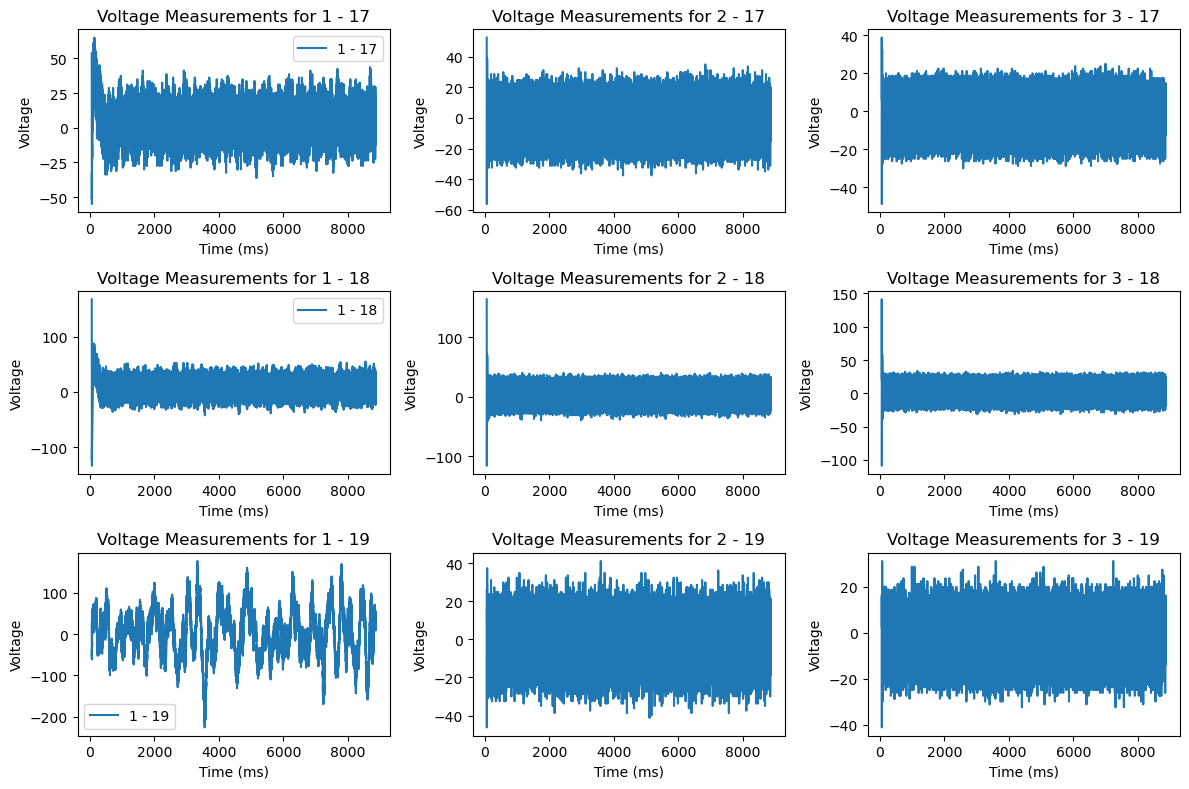

In [15]:
## TXT to numpy

data = np.loadtxt(electro_phi_path + ELECTROPHI_FILENAME, skiprows=1, delimiter='\t', encoding='ascii')
#Extract time and each numbered column into separate arrays
time_10kHz = data[:, 0]
voltages = data[:, 1:len(FILTERS)*len(GATES)+1]

##Label
labels = [f'{filter} - {gate}' for filter in FILTERS for gate in GATES]
voltages_dict = {label: voltages[:, i] for i, label in enumerate(labels)}

#Plotting each filter-gate combination in separate plots
num_plots = len(labels)
num_cols = len(FILTERS)
num_rows = len(GATES)

plt.figure(figsize=(12, 8))

for i, gate in enumerate(GATES):
    for j, filter in enumerate(FILTERS):
        plt.subplot(num_rows, num_cols, i*num_cols +j +1)
        label = f'{filter} - {gate}'
        plt.plot(time_10kHz, voltages_dict[label], label=label)
        plt.xlabel('Time (ms)')
        plt.ylabel('Voltage')
        plt.title(f'Voltage Measurements for {label}')
        if j == 0:
            plt.legend()

plt.tight_layout()
plt.show()

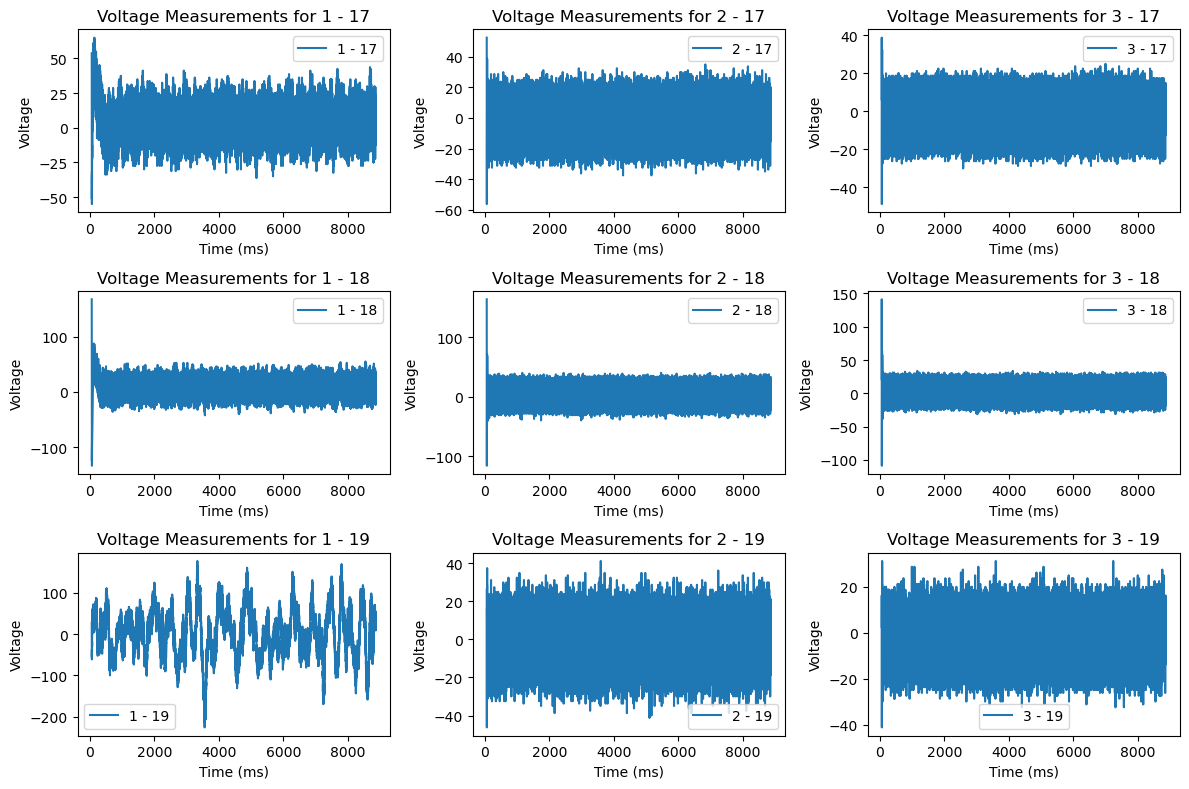

In [ ]:
import threading

# Assuming you have already loaded data and defined the necessary variables

## TXT to numpy
data = np.loadtxt(electro_phi_path + ELECTROPHI_FILENAME, delimiter='\t', encoding='ascii')
# Extract time and each numbered column into separate arrays
time_10kHz = data[:, 0]
voltages = data[:, 1:len(FILTERS)*len(GATES)+1]

## Label
labels = [f'{filter} - {gate}' for filter in FILTERS for gate in GATES]
voltages_dict = {label: voltages[:, i] for i, label in enumerate(labels)}

# Plotting each filter-gate combination in separate plots
num_cols = len(FILTERS)
num_rows = len(GATES)

def plot_graph(ax, label, time, data):
    ax.plot(time, data, label=label)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Voltage')
    ax.set_title(f'Voltage Measurements for {label}')
    ax.legend()

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

threads = []
for i, gate in enumerate(GATES):
    for j, filter in enumerate(FILTERS):
        label = f'{filter} - {gate}'
        thread = threading.Thread(target=plot_graph, args=(axs[i, j], label, time_10kHz, voltages_dict[label]))
        thread.start()
        threads.append(thread)

for thread in threads:
    thread.join()

plt.tight_layout()
plt.show()


#### Frame by Frame display
This display plots according to the time, 30 measures per second should be displayed. </br>
The original data is displayed in ms and micro-Volts. We want to keep only 30 out of 


In [16]:
from IPython.display import clear_output

KeyboardInterrupt: 

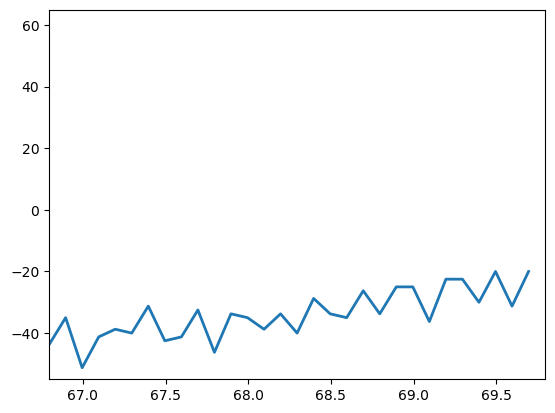

In [18]:
# Sample data
t = time_10kHz  # Example time data # Example voltage data
x = voltages[:, 0]

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(0, 2)
ax.set_ylim(np.min(x), np.max(x))

for i in range(1, len(x)):
    line.set_data(t[:i], x[:i])
    ax.set_xlim(t[max(0, i-30)], t[i])  # Adjust window size to your preference
    clear_output(wait=True)
    display(fig)

plt.show()

#### Simultaneous Display
It seems matplotlib is not thread safe for a threaded implementation. Below implementation seems correct, but unsupported. A switch to another method of viewing might be preferred.
This highlights also a potential future issue : Displaying and analyzing combined video and electrophysiological data.
(Use of pyQT graph?)

In [21]:
## TXT to numpy
data = np.loadtxt(live_path + ELECTROPHI_FILENAME, delimiter='\t', encoding='ascii')
# Extract time and each numbered column into separate arrays
time_10kHz = data[:, 0]
voltages = data[:, 1:len(FILTERS)*len(GATES)+1]

## Label
labels = [f'{filter} - {gate}' for filter in FILTERS for gate in GATES]
voltages_dict = {label: voltages[:, i] for i, label in enumerate(labels)}

# Plotting each filter-gate combination in separate plots
num_cols = len(FILTERS)
num_rows = len(GATES)

def trace(ax, label, time_10kHz, data):
    line, = ax.plot([], [], lw=2)
    ax.set_xlim(0, 2)
    ax.set_ylim(np.min(data), np.max(data))
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Voltage')
    ax.set_title(f'Voltage Measurements for {label}')
    return line

def plot_graph(ax, label, time_10kHz, data):
    line = trace(ax, label, time_10kHz, data)
    for k in range(1, len(time_10kHz)):
        line.set_data(time_10kHz[:k], data[:k])
        ax.set_xlim(time_10kHz[max(0, k-30)], time_10kHz[k])
        clear_output(wait=True)
        display(fig)

###FIGURE
plt.figure(figsize=(12, 8))

for i, gate in enumerate(GATES):
    for j, filter in enumerate(FILTERS):
        fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols)
        label = f'{filter} - {gate}'
        #plot_graph(ax[i, j], label, time_10kHz, voltages_dict[label])
        thread = threading.Thread(target=plot_graph, args=(axs[i, j], label, time_10kHz, voltages_dict[label]))
        thread.start()
        threads.append(thread)
        if j == 0:
            plt.legend()


for thread in threads:
    thread.join()
    
plt.tight_layout()
plt.show()


FileNotFoundError: C:/Users/radja/Documents/COURS/RSRC/CARDIO-visualization/data/LIVE test/OUT_17-18-19_1-2-3_09-07-2024_17-23.txt not found.

### Combining Electrophysiological and visual data
In the below implementation, we will reshape our numpy arrays to fit a video implementation, in 30FPS.
Currently, our data is fixed on a 10kHz bandwidth, which makes precise association to a video stream difficult.

#### Mean values obtention.
This first version does not consider outlier spikes, which is actually the data that interests us.

In [22]:
FPS = 30

In [23]:
downsample_factor = FPS

def downsample_flatten_data(voltage, t):
    downsample_factor = downsample_factor *10
    num_rows, num_columns = voltages.shape
    ###Number of full chunks of num_rows/downsample_factor and the remainder :
    num_full_chunks = num_rows // downsample_factor
    remaining_rows = num_rows % downsample_factor
    print(num_full_chunks, remaining_rows)

    #FULL CHUNKS
    #########Of Voltages
    full_chunks_volt = voltages[:num_full_chunks * downsample_factor].reshape(num_full_chunks, downsample_factor, num_columns)
    downsampled_full_volt = full_chunks_volt.mean(axis=1)
    #########Of Time
    full_chunks_time = time_10kHz[:num_full_chunks * downsample_factor].reshape(num_full_chunks, downsample_factor)
    downsampled_full_time = full_chunks_time.mean(axis=1)

    #REMAINDER, if existing
    if remaining_rows > 0:
        remaining_chunk_volt = voltages[num_full_chunks * downsample_factor:]
        remaining_chunk_time = time_10kHz[num_full_chunks * downsample_factor:]
        downsampled_remaining_volt = remaining_chunk_volt.mean(axis=0)
        downsampled_remaining_time = remaining_chunk_time.mean(keepdims=True)
        #Combine FULL and REMAINDER
        downsampled_voltages = np.vstack([downsampled_full_volt, downsampled_remaining_volt])
        downsampled_time = np.concatenate([downsampled_full_time, downsampled_remaining_time])
    else:
        downsampled_voltages= downsampled_full_volt
        downsampled_time= downsampled_full_time

    print("Downsampled shapes :", downsampled_voltages.shape, downsampled_time.shape)
    return downsampled_time, downsampled_voltages
downsampled_time, downsampled_voltages = downsample_flatten_data(voltages, time_10kHz)
print(downsampled_voltages)


UnboundLocalError: cannot access local variable 'downsample_factor' where it is not associated with a value

### Outlier consideration
This version is the one that interests us for data analysis.

In [28]:
import numpy as np

downsample_factor = 30  # For your case with 30 FPS

def downsample_data(voltage, t, threshold=40, downsample_factor=30):
    downsample_factor= downsample_factor*10
    num_rows, num_columns = voltage.shape
    num_full_chunks = num_rows // downsample_factor
    remaining_rows = num_rows % downsample_factor
    print(num_full_chunks, remaining_rows)

    def process_chunk(chunk):
        mean_chunk = chunk.mean(axis=0)
        abs_diff = np.abs(chunk - mean_chunk)
        #check if any value in chunk > or < than the threshold
        if np.any(abs_diff > threshold):
            #if there is a large enough difference, keep the largest value (positive or negative)
            #####in the case where within one chunk of ~33333 values there are two spikes (one positive and one negative), 
            ####this implementation considers the value with the biggest difference. Further implementation should consider a flag when this happens
            result = np.max(chunk, axis=0) if (np.max(chunk) > np.abs(np.min(chunk)) and np.max(chunk) >np.min(chunk, axis=0)) else np.min(chunk, axis=0)
        else:
            # Otherwise, use the mean
            result = mean_chunk
        return result
    
    # FULL CHUNKS
    full_chunks_volt = voltage[:num_full_chunks * downsample_factor].reshape(num_full_chunks, downsample_factor, num_columns)
    downsampled_full_volt = np.apply_along_axis(process_chunk, 1, full_chunks_volt)
    
    full_chunks_time = t[:num_full_chunks * downsample_factor].reshape(num_full_chunks, downsample_factor)
    downsampled_full_time = full_chunks_time.mean(axis=1)

    # REMAINDER, if existing
    if remaining_rows > 0:
        remaining_chunk_volt = voltage[num_full_chunks * downsample_factor:]
        remaining_chunk_time = t[num_full_chunks * downsample_factor:]
        downsampled_remaining_volt = process_chunk(remaining_chunk_volt)
        downsampled_remaining_time = remaining_chunk_time.mean(keepdims=True)
        # Combine FULL and REMAINDER
        downsampled_voltages = np.vstack([downsampled_full_volt, downsampled_remaining_volt])
        downsampled_time = np.concatenate([downsampled_full_time, downsampled_remaining_time])
    else:
        downsampled_voltages = downsampled_full_volt
        downsampled_time = downsampled_full_time

    print("Downsampled shapes:", downsampled_voltages.shape, downsampled_time.shape)
    return downsampled_time, downsampled_voltages

# Example usage
downsampled_time, downsampled_voltages = downsample_data(voltages, time_10kHz)
print(downsampled_voltages)


293 100
Downsampled shapes: (294, 9) (294,)
[[-5.50000000e+01  1.67500000e+02 -6.12500000e+01 ... -4.87500000e+01
   1.41250000e+02 -4.12500000e+01]
 [ 3.24791667e+01  4.23958333e+01  4.54666667e+01 ... -1.68750000e+00
  -1.36666667e+00 -2.50416667e+00]
 [ 3.95500000e+01  5.12708333e+01  3.01166667e+01 ... -9.79166667e-01
  -1.25833333e+00 -4.41666667e-01]
 ...
 [-2.58750000e+00  5.12500000e+01  7.00000000e+01 ... -3.83333333e-01
  -1.18333333e+00 -1.65833333e+00]
 [ 4.87083333e+00  7.54166667e+00  4.47416667e+01 ... -1.81666667e+00
  -1.81250000e+00 -1.33750000e+00]
 [ 4.57500000e+00 -4.62500000e-01  3.03875000e+01 ... -5.00000000e-02
  -4.75000000e-01 -9.87500000e-01]]


#### Using Z-score (for stats)

In [ ]:
from scipy.stats import zscore

downsample_factor = 30  # For your case with 30 FPS

def downsample_data(voltage, t, threshold=3):
    num_rows, num_columns = voltage.shape
    num_full_chunks = num_rows // downsample_factor
    remaining_rows = num_rows % downsample_factor
    print(num_full_chunks, remaining_rows)

    def process_chunk(chunk):
        # Calculate the Z-score to identify outliers
        z_scores = np.abs(zscore(chunk, axis=0))
        # Find maximum Z-score for outlier detection
        max_z_scores = np.max(z_scores, axis=0)
        
        # For each column, decide whether to keep the outlier or use the mean
        result = np.where(max_z_scores > threshold, np.max(chunk, axis=0), chunk.mean(axis=0))
        return result
    
    # FULL CHUNKS
    full_chunks_volt = voltage[:num_full_chunks * downsample_factor].reshape(num_full_chunks, downsample_factor, num_columns)
    downsampled_full_volt = np.apply_along_axis(process_chunk, 1, full_chunks_volt)
    
    full_chunks_time = t[:num_full_chunks * downsample_factor].reshape(num_full_chunks, downsample_factor)
    downsampled_full_time = full_chunks_time.mean(axis=1)

    # REMAINDER, if existing
    if remaining_rows > 0:
        remaining_chunk_volt = voltage[num_full_chunks * downsample_factor:]
        remaining_chunk_time = t[num_full_chunks * downsample_factor:]
        downsampled_remaining_volt = process_chunk(remaining_chunk_volt)
        downsampled_remaining_time = remaining_chunk_time.mean(keepdims=True)
        # Combine FULL and REMAINDER
        downsampled_voltages = np.vstack([downsampled_full_volt, downsampled_remaining_volt])
        downsampled_time = np.concatenate([downsampled_full_time, downsampled_remaining_time])
    else:
        downsampled_voltages = downsampled_full_volt
        downsampled_time = downsampled_full_time

    print("Downsampled shapes:", downsampled_voltages.shape, downsampled_time.shape)
    return downsampled_time, downsampled_voltages

downsampled_time_z, downsampled_voltages_z = downsample_data(voltages, time_10kHz)


3300 0
Downsampled shapes: (3300, 9) (3300,)


#### Displaying Downsampled data to 30 'FPS'

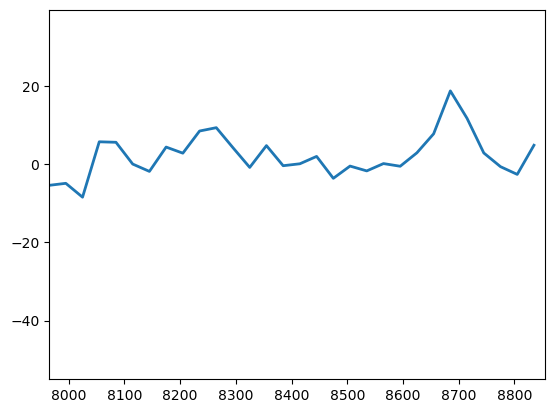

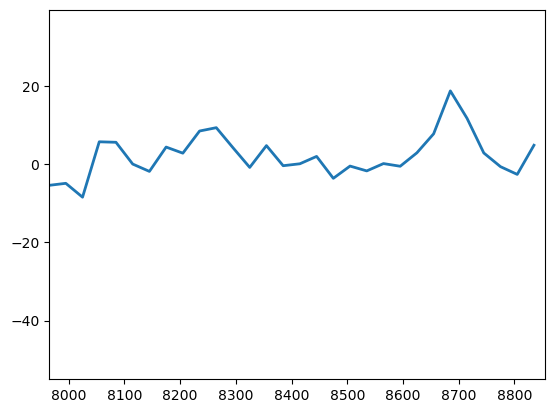

In [30]:
###DISPLAY
# D
t = downsampled_time  # Example time data # Example voltage data
x = downsampled_voltages[:, 0]

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(0, 2)
ax.set_ylim(np.min(x), np.max(x))

for i in range(1, len(x)):
    line.set_data(t[:i], x[:i])
    ax.set_xlim(t[max(0, i-FPS)], t[i])  # Adjust window size to your preference
    clear_output(wait=True)
    display(fig)

plt.show()

#### Associate electrophysiological data to Video file.
This segment of code will take the duration of measurements along with the creation time of MC\_TEMP.mcd file to associate it to a video file that could potentially overlap. There is one ground rule : electrophysiological measures should be started recording first. 
The videos will be stored in the '.../data/video_data/' folder, and their associated electrodes coordinates into the '.../data/bounding_rect/' folder.
- To save time and repertoriate different recordings along with their associated data, indexation will be done within the "ASSOCIATION.idx" file.

In [ ]:
rect_path = data_path + 'bounding_rect_data/'
vid_path  = data_path + 'video_data/'

#### Indexation function
The indexation function "association", opens two temporary file streams which iterate over each comparative's associated folders, to index which video file corresponds to which electrophysiological data file. 

In [ ]:
from datetime import timedelta

In [ ]:
###takes two file names, checks if dates are the same
def same_date_time(preciseness_scale, DT1, DT2):
    return True

def do_overlap(DT1, DT2, duration):
    if DT1 + timedelta(seconds=duration):
        return

def is_corresponding(video_file_name, vids_path, MCD_FILEPATH, rects_path, fps):
    _ , _ , video_timeframe = get_file_creation_time(vids_path + video_file_name)
    _ , _ , electroPHI_timeframe = get_file_creation_time(MCD_FILEPATH)
    if(video_timeframe > electroPHI_timeframe):
        with open(rects_path + video_file_name[:-4], 'rb') as f:
            try:  #catch OSError in case of a one line file 
                f.seek(-2, os.SEEK_END)
                while f.read(1) != b'\n':
                    f.seek(-2, os.SEEK_CUR)
            except OSError:
                f.seek(0)
            nb_frames = int(f.readline().decode())
            video_duration = nb_frames/1*fps
            print(video_duration, "seconds elapsed")
            
        print(video_timeframe + timedelta(milliseconds=500))
        return True

is_corresponding('10-06-2024_18-04.avi', vid_path, MC_TEMP[1:-1], rect_path, FPS)

In [ ]:
def association(electro_phi_folder, video_folder, association_file):
    ####BREAKS down each electrophysiology element from association file into a np array of dates
    #Extract the first column
    with open(association_file, 'r') as file:
        lines = file.readlines()
    association_file_line_split = [line.split()[0] for line in lines]
    # Convert the list to a NumPy array
    electroPHI_idx = np.array(association_file_line_split)

    ###iterates through folder
    for filename in os.listdir(electro_phi_folder):
        electroPHI_file_path = os.path.join(electro_phi_folder, filename)
        if os.path.isfile(electroPHI_file_path):  # Check if it's a file
            print(f"File: {filename}")
            ###Check if it's within the association file already
            if(filename not in electroPHI_idx):
                ###if no, append it, and search for it's partner in video_folder
                ##return False
                # If not, append it to the association file
                
                
                # Search for its associated video in the video_folder
                for video_filename in os.listdir(video_folder):
                    video_file_path = os.path.join(video_folder, video_filename)
                    if os.path.isfile(video_file_path):
                        if(is_corresponding(video_filename, vid_path, MC_TEMP[1:-1], rect_path, FPS)):
                            with open(association_file, 'a') as file:
                                file.write(f"\n{filename} ")
                                print(f"Added {filename} to the association file.")
                            file.write(f"{video_filename} ")

#### Update function
This function is launched everytime a recording is stopped, so as to update necessary variables and values. For example, it will "re-edit" rectangle data files, update the index file, ...

In [ ]:
def update():
    association(electro_phi_path, vid_path, data_path + 'ASSOCIATION.idx')

update()

File: init
2460.0 seconds elapsed
2024-08-01 16:43:05.821836
Added init to the association file.


C:\Users\radja\AppData\Local\Temp\ipykernel_2220\561787965.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if(filename not in electroPHI_idx):


ValueError: I/O operation on closed file.

#### Data Combination
This function will combine two files and reshape data using downsample_data 

In [ ]:
def combine(electroPHI_file, bounding_rect_file):
## TXT to numpy

    ###ELECTROPHISIOLOGY DATA
    data = np.loadtxt(electroPHI_file, delimiter='\t', encoding='ascii')
    # Extract time and each numbered column into separate arrays
    time_10kHz = data[:, 0]
    voltages = data[:, 1:len(FILTERS)*len(GATES)+1]

    ## Label
    labels = [f'{filter} - {gate}' for filter in FILTERS for gate in GATES]
    voltages_dict = {label: voltages[:, i] for i, label in enumerate(labels)}
    downsampled_time, downsampled_voltages = downsample_data(voltages, time_10kHz)

    ###RECTANGLES DATA.
    

